In [1]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
# Processing
import numpy as np
np.random.seed(0)
import random
import json
import pandas as pd
from datetime import datetime, timedelta

import pickle
import requests
from urllib.parse import urlencode
from sklearn.preprocessing import LabelEncoder
import json

# Visualisation
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from plotnine import ggplot, aes, geom_bar, theme_minimal, labs


# 项目结论

# Thinking Engine data


Dispute monitoring report:

http://td.winnerstudio.vip:8996/#/panel/panel/39_3423



## Time since payment and install

- Time since payment: http://td.winnerstudio.vip:8996/#/tga/ide/59_22269?tab=result

- Time since install: http://td.winnerstudio.vip:8996/#/tga/ide/59_22267


Next steps: 

- Can u find the dispute ID? 
- Then from that try to find out why a unique payment is associated to multiple rows? 
- Then check if after correcting this the join of predictions and regressors does not generate a movement in the rows of the response dataset. 
- Apply corrections across the analysis including the dashboards

# Response

In [3]:
# @title Function to pull data from the API
bs_token = 'lWYPGrEyZ0xqY7CJGTMx3DP60VBxZ21v7yrHjKguyGtQY2C5z16og6N8zu0R4Mbw'
host = 'td.winnerstudio.vip'

def pull_data(sql_script):

    data = {
        'token':          bs_token,
        'format':         'json_object',
        'timeoutSeconds': 1000,
        'sql':            sql_script
    }

    data = str(urlencode(data))
    response = requests.post(f'http://{host}:8992/querySql?{data}', timeout = 1000000)

    # Sample list of JSON strings
    json_list = response.text.split('\n')[1:]

    # Convert JSON strings to dictionaries
    dict_list = []
    for json_str in json_list:
        try:
            dict_list.append(json.loads(json_str))
        except json.JSONDecodeError as e:
            print(f"Error parsing JSON: {e}")

    # Create a pandas DataFrame
    data = pd.DataFrame(dict_list).sort_index(axis=1)

    # Display the DataFrame
    return data


The objective also is to find the measure of success. So the model needs to fit well the probabilities over time.

DECISION I 

- Consider only payments before the last 60 days: Reason, some of those payments can be succeptible of being disputed but hav enot been disputed yet. 
- Consider only payers that installed the game after september: Maybe before september it is too early 
- Acorn casino iOS: Only iOS version is active

In [5]:
RESPONSE_SQL = """

-- Payments (Payments with K month maturity). You can implement this to a later time.
with payment_aux as (
select *
from ta.v_event_59
where "$part_event" = 'order_pay'
    and  date_diff('day', "#event_time", current_date) < 60 -- Before the last 60 days
    and cast(date_format("#event_time", '%Y-%m-%d') as varchar) > '2023-11-01'
    and ("is_true" is null or "is_true" = true)
    and "$part_date" is not null)

-- Payments of users that have installed the app, after July last year (I want to filter to have users that installed), and are iOS devices.
-- Intersection of recently registered users and users that have made any of the payments above
, ios_payments as (
select
    a."#account_id"
    , b."register_time"
    , a."pay_id"
    , a."#event_time"                                               as "pay_time"
    , avg(if((c."#event_time" is not null), 1, 0))                  as "is_disputed"
from payment_aux as a
  join ta.v_user_59 as b                                                                                                  on a."#account_id" = b."#account_id"   and     a."#event_time" > b."register_time"
  left join (select * from ta.v_event_59 where "$part_event" = 'pay_dispute' and "$part_date" is not null) as c           on a.pay_id        = c.pay_id
where cast(date_format(b."register_time", '%Y-%m-%d') as varchar) > '2023-09-01'
  and b."bundle_id" = 'com.acorncasino.slots'
group by 1,2,3,4
)

select
    "#account_id"
    , "register_time"
    , avg("is_disputed") as dispute_rate
    , count(*)           as valid_payments
from ios_payments
group by 1,2

"""

In [7]:
response_data = pull_data(RESPONSE_SQL)

KeyboardInterrupt: 

In [6]:
response_data.sample(10)

NameError: name 'response_data' is not defined

### The more payments the more likely to dispute at least one

In [9]:
print('付费用户 count：  ', response_data[response_data['dispute_rate'] > 0].shape[0])
print('付费用户 with any dispute in 3 months：  ', response_data[response_data['dispute_rate'] > 0].shape[0] / response_data.shape[0])

付费用户 count：   547
付费用户 with any dispute in 3 months：   0.011262791607470093


In [10]:
print('付费用户 count：  ', response_data[response_data['valid_payments'] == 1][response_data['dispute_rate'] > 0].shape[0])
print('付费用户 with any dispute in 3 months：  ', response_data[response_data['valid_payments'] == 1][response_data['dispute_rate'] > 0].shape[0] / response_data[response_data['valid_payments'] == 1].shape[0])

付费用户 count：   118
付费用户 with any dispute in 3 months：   0.006462212486308872


In [11]:
print('付费用户 count：  ', response_data[response_data['valid_payments'] > 1][response_data['dispute_rate'] > 0].shape[0])
print('付费用户 with any dispute in 3 months：  ', response_data[response_data['valid_payments'] > 1][response_data['dispute_rate'] > 0].shape[0] / response_data[response_data['valid_payments'] > 1].shape[0])

付费用户 count：   429
付费用户 with any dispute in 3 months：   0.014155145675916456


In [12]:
print('付费用户 count：  ', response_data[response_data['valid_payments'] > 2][response_data['dispute_rate'] > 0].shape[0])
print('付费用户 with any dispute in 3 months：  ', response_data[response_data['valid_payments'] > 2][response_data['dispute_rate'] > 0].shape[0] / response_data[response_data['valid_payments'] > 2].shape[0])

付费用户 count：   376
付费用户 with any dispute in 3 months：   0.016404170847694254


### The more payments the less likely to dispute them all

In [13]:
print('付费用户 count：  ', response_data[response_data['dispute_rate'] > 0].shape[0])
print('付费用户 with any dispute in 3 months：  ', response_data[response_data['dispute_rate'] > 0].shape[0] / response_data.shape[0])

付费用户 count：   547
付费用户 with any dispute in 3 months：   0.011262791607470093


In [14]:
print('付费用户 count：  ', response_data[response_data['valid_payments'] == 1][response_data['dispute_rate'] == 1].shape[0])
print('付费用户 with any dispute in 3 months：  ', response_data[response_data['valid_payments'] == 1][response_data['dispute_rate'] == 1].shape[0] / response_data[response_data['valid_payments'] == 1].shape[0])

付费用户 count：   118
付费用户 with any dispute in 3 months：   0.006462212486308872


In [15]:
print('付费用户 count：  ', response_data[response_data['valid_payments'] > 1][response_data['dispute_rate'] == 1].shape[0])
print('付费用户 with any dispute in 3 months：  ', response_data[response_data['valid_payments'] > 1][response_data['dispute_rate'] == 1].shape[0] / response_data[response_data['valid_payments'] > 1].shape[0])

付费用户 count：   65
付费用户 with any dispute in 3 months：   0.0021447190418055237


In [16]:
print('付费用户 count：  ', response_data[response_data['valid_payments'] > 2][response_data['dispute_rate'] == 1].shape[0])
print('付费用户 with any dispute in 3 months：  ', response_data[response_data['valid_payments'] > 2][response_data['dispute_rate'] == 1].shape[0] / response_data[response_data['valid_payments'] > 2].shape[0])

付费用户 count：   46
付费用户 with any dispute in 3 months：   0.002006893242005148


# Measure of performance

So, it seems we want the model to find high probabilities, and those probabilities to be correctly fit. That is, to have some confidence.

Overall, 50 sample size is good for me.

We also want to see the performance over time. Try 3 months.

DECISION II: How to measure performance. Overall we want a system that can detect high probabilities. However we want those probabilities to be reliable. So we have to check them with new data. 

In [7]:
validation_sets = 3
response_data['date'] = pd.to_datetime(response_data['register_time']).apply(lambda x: int(x.strftime('%Y%m%d')))
response_data['validation_set_id'] = pd.qcut(response_data['date'].values, validation_sets)
response_data.groupby('validation_set_id').size()

validation_set_id
(20230901.999, 20240109.0]    14730
(20240109.0, 20240130.0]      14358
(20240130.0, 20240304.0]      14333
dtype: int64

DECISION III: Who is a disputer

In [8]:
response_data['disputer'] = (response_data['dispute_rate'] > 0).astype(int)
payment_cols = ['valid_payments', 'disputer']
response_data['disputer'].mean()

0.0111236498468483

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

def create_model(criterion, depth, leaf_size, cols):

    # preprocessor = ColumnTransformer(
    #     transformers = [
    #         ('scaler', StandardScaler(), cols)
    #     ],
    #     remainder='passthrough'
    # )

    # Create the pipeline
    pipe = Pipeline([
        # ('preprocessor', preprocessor),
        # ('regressor', DecisionTreeClassifier(criterion = criterion, max_depth = depth, min_samples_leaf = leaf_size))
        ('regressor', RandomForestClassifier(criterion = criterion, max_depth = depth, min_samples_leaf = leaf_size))
    ])

    return pipe


In [10]:
from tqdm import tqdm, tqdm_notebook
from sklearn.metrics import accuracy_score, precision_score


model_results = []
all_model_results = []
criteria = ['gini', 'entropy', 'log_loss']
criteria = ['gini']
depths = [10, 11]
leaf_sizes = [10, 20, 30]
cols = ['valid_payments']

# for train_index, test_index in splits:
for date_group in response_data['validation_set_id'].unique():

    train_data =  response_data[response_data['validation_set_id'] != date_group][payment_cols]
    test_data =  response_data[response_data['validation_set_id'] == date_group][payment_cols]

    # Separate features (X) and target variable (y)
    X_train, y_train = train_data.drop(columns = [f'disputer']), train_data[f'disputer']
    X_test, y_test = test_data.drop(columns = [f'disputer']), test_data[f'disputer']

    # old_cols = X_train.copy().columns
    # X_train = all_feature_enginerring(X_train, y_train)
    # X_test = all_feature_enginerring(X_test, y_test)

    for criterion in tqdm(criteria):

        for depth in depths:

            for leaf_size in leaf_sizes:

              model = create_model(criterion, depth, leaf_size, cols)

              try:
                  model.fit(X_train[cols], y_train)
                  predictions = model.predict(X_test[cols])
                  accuracy = accuracy_score(y_test, predictions)
                  prec = precision_score(y_test, predictions)

              except:
                  model = np.nan
                  predictions = np.nan
                  mae = np.nan
                  r2 = np.nanZ

              predictions = model.predict_proba(X_test[cols])

              # Save the model into dictionary (Response, day, mo...)
              model_result = pd.DataFrame({
                  'Iteration': [str(criterion) + ' - ' + str(depth) + ' - ' + str(leaf_size)]
                  , 'Test at': [date_group]
                  , 'Model': [model]
                  , 'accuracy': [accuracy]
                  , 'precission': [prec]
                  # , 'rel_mae': [(((y_test - y_test.mean()).abs()).mean() - mae) / (((y_test - y_test.mean()).abs()).mean())]
              })

              model_results.append(model_result)

    all_model_results.extend(model_results)

all_model_results = pd.concat(all_model_results, ignore_index = True)#.sort_values(by = ['Available day', 'Model'])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:02<?, ?it/s]


AttributeError: module 'numpy' has no attribute 'nanZ'

In [20]:
(1 - predictions[:, 0]).max()

0.12546442483338704

In [21]:
amrgb = all_model_results.groupby('Iteration')[['accuracy', 'precission']].mean().sort_values(by = 'accuracy', ascending = False).reset_index(drop = False)
amrgb

,Iteration,accuracy,precission
0,gini - 10 - 10,0.989878,0.0
1,gini - 10 - 20,0.989878,0.0
2,gini - 10 - 30,0.989878,0.0
3,gini - 11 - 10,0.989878,0.0
4,gini - 11 - 20,0.989878,0.0
5,gini - 11 - 30,0.989878,0.0


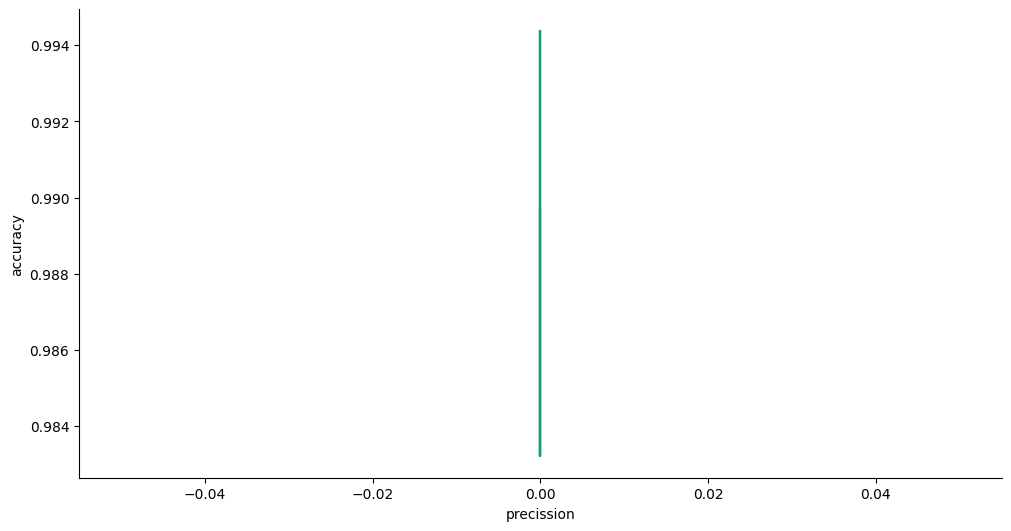

In [22]:
# @title precission vs accuracy

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['precission']
  ys = series['accuracy']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = all_model_results.sort_values('precission', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('precission')
_ = plt.ylabel('accuracy')

In [ ]:
best_clf = all_model_results[all_model_results['Iteration'] == 'log_loss - 5 - 20']['Model'].values[0][1]
# selected_indices = all_model_results[all_model_results['Iteration'] == 'log_loss - 5 - 20']['Model'].values[0][1]['step_1']
best_clf

In [ ]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

# Create the decision tree classifier
clf = all_model_results[all_model_results['Iteration'] == 'log_loss - 4 - 30']['Model'].values[0][1]

# Train the classifier with your data

# Assuming you have your data stored in X_train and y_train
# clf.fit(X_train, y_train)

# Visualize the decision tree
dot_data = export_graphviz(clf,
                           out_file = None
                           ,  feature_names = cols
                          #  ,  class_names=True
                           ,  label = 'none'
                           ,  filled=True
                           ,  leaves_parallel = True
                           ,  proportion = True
                           ,  rounded=False
                           ,  special_characters=True)

graphviz.Source(dot_data)



In [ ]:
# Visualize the decision tree
dot_data = export_graphviz(clf,
                           out_file = None
                           ,  feature_names = cols
                          #  ,  class_names=True
                           ,  label = 'none'
                           ,  filled = True
                           ,  leaves_parallel = True
                           ,  proportion = False
                           ,  rounded = False
                           ,  special_characters = True)

graphviz.Source(dot_data)

The next thing is that the model needs to make sense. I don't want to use the behavior after disputing right? So you need to look at the behaviour in a particular moment in time.

# Predictors

Pull and join them. It is okay.

 - You can use basic PLTV data: Withdrawal, etc.
 - Activity

In [11]:

# I am getting all the payers. Making a any payment after Novemeber. And making any payment before the last 60 days. 
# Then, I am truncating them 

RESPONSE_SQL = """

-- Payments (Payments with K month maturity). You can implement this to a later time.
with payment_aux as (
select *
from ta.v_event_59
where "$part_event" = 'order_pay'
    and  date_diff('day', "#event_time", current_date) < 60 -- Before the last 60 days
    and cast(date_format("#event_time", '%Y-%m-%d') as varchar) > '2023-11-01'
    and ("is_true" is null or "is_true" = true)
    and "$part_date" is not null)

-- Payments of users that have installed the app, after July last year (I want to filter to have users that installed), and are iOS devices.
-- Intersection of recently registered users and users that have made any of the payments above
, ios_payments as (
select
    a."#account_id"
    , b."register_time"
    , a."pay_id"
    , a."#event_time"                                               as "pay_time"
    , avg(if((c."#event_time" is not null), 1, 0))                  as "is_disputed"
from payment_aux as a
  join ta.v_user_59 as b                                                                                                  on a."#account_id" = b."#account_id"   and     a."#event_time" > b."register_time"
  left join (select * from ta.v_event_59 where "$part_event" = 'pay_dispute' and "$part_date" is not null ) as c           on a.pay_id        = c.pay_id
where cast(date_format(b."register_time", '%Y-%m-%d') as varchar) > '2023-09-01'
  and b."bundle_id" = 'com.acorncasino.slots'
group by 1,2,3,4
)

select
    "#account_id"
    , "register_time"
    , avg("is_disputed") as dispute_rate
    , count(*)           as valid_payments
from ios_payments
group by 1,2

"""

In [12]:
"""
# @title SQL Tables
"""

today = datetime.today()
start_date = '2023-09-01'
end_date = today - timedelta(days = 60)


import types

USER_PAYMENT = f"""
with payment_aux as (
select "#event_time", "pay_enter_name", "payment_type","#account_id", "#os", cast("net_amount" as double) as na
from ta.v_event_59
where "$part_event" = 'order_pay'
    and  date_diff('day', "#event_time", current_date) < 60 -- Before the last 60 days
    and cast(date_format("#event_time", '%Y-%m-%d') as varchar) > '2023-11-01'
    and ("is_true" is null or "is_true" = true)
    and "$part_date" is not null)

select
a."#account_id"
,cast(date_format(date_add('hour', 8, a."register_time"),'%Y-%m-%d') as varchar) as "register_time"
,sum(if(date_diff('day',a."register_time",b."#event_time")<=35,na,0))            as p35
,sum(if(date_diff('day',a."register_time",b."#event_time")<=42,na,0))            as p42
,sum(if(date_diff('day',a."register_time",b."#event_time")<=49,na,0))            as p49
,sum(if(date_diff('day',a."register_time",b."#event_time")<=56,na,0))            as p56
,sum(if(date_diff('day',a."register_time",b."#event_time")<=91,na,0))            as p91
,sum(if(date_diff('day',a."register_time",b."#event_time")<=133,na,0))           as p133
,sum(if(date_diff('day',a."register_time",b."#event_time")<=28,na,0))            as p28
,sum(if(date_diff('day',a."register_time",b."#event_time")<=14,na,0))            as p14
,sum(if(date_diff('day',a."register_time",b."#event_time")<=7,na,0))             as p7
,sum(if(date_diff('day',a."register_time",b."#event_time")<=6,na,0))             as p6
,sum(if(date_diff('day',a."register_time",b."#event_time")<=5,na,0))             as p5
,sum(if(date_diff('day',a."register_time",b."#event_time")<=4,na,0))             as p4
,sum(if(date_diff('day',a."register_time",b."#event_time")<=3,na,0))             as p3
,sum(if(date_diff('day',a."register_time",b."#event_time")<=2,na,0))             as p2
,sum(if(date_diff('day',a."register_time",b."#event_time")<=1,na,0))             as p1
,sum(if(date_diff('hour',a."register_time",b."#event_time")<=6,na,0))            as ph6
,sum(if(date_diff('hour',a."register_time",b."#event_time")<=1,na,0))            as ph1
,sum(if(date_diff('day',a."register_time",b."#event_time")<=7,1,0))              as cp7
,sum(if(date_diff('day',a."register_time",b."#event_time")<=3,1,0))              as cp3
,sum(if(date_diff('day',a."register_time",b."#event_time")<=1,1,0))              as cp1
from ta.v_user_59 as a
  left join payment_aux as b
    on a."#account_id" = b."#account_id"
    and a."register_time" < b."#event_time"
    and date_diff('day', a."register_time", b."#event_time") <= 90
where cast(date_format(a."register_time", '%Y-%m-%d') as varchar) > '2023-09-01'
  and a."bundle_id" = 'com.acorncasino.slots'
group by 1,2
"""

WITHDRAWALS = f"""

with cash_withdrawals_success as (
select "#account_id","withdraw_id","#event_time","amount","withdraw_fee"
from v_event_59 where "$part_event"='withdraw_success' and "$part_date" is not null)

, cash_withdrawals_applied as (
select "#account_id","withdraw_id","#event_time","amount","withdraw_fee"
from v_event_59 where "$part_event"='withdraw_apply' and "$part_date" is not null)

, withdrawals_aux as (
select
 a."#account_id"
 , a."withdraw_id"
 , a."#event_time"                      as withdrawal_apply_time
 , a."amount" - a."withdraw_fee"        as withdrawal_amount
 , b."#event_time"                      as ws_t
 , b."amount" - b."withdraw_fee"        as withdrawal_succes_amount
 , b."amount"                           as wa
from cash_withdrawals_applied a
  left join cash_withdrawals_success b on a."withdraw_id" = b."withdraw_id")

select
 a."#account_id"
 ,sum(if(date_diff('day',a."register_time",ws_t)<=28,wa,0)) as w28
 ,sum(if(date_diff('day',a."register_time",ws_t)<=27,wa,0)) as w27
 ,sum(if(date_diff('day',a."register_time",ws_t)<=26,wa,0)) as w26
 ,sum(if(date_diff('day',a."register_time",ws_t)<=25,wa,0)) as w25
 ,sum(if(date_diff('day',a."register_time",ws_t)<=24,wa,0)) as w24
 ,sum(if(date_diff('day',a."register_time",ws_t)<=23,wa,0)) as w23
 ,sum(if(date_diff('day',a."register_time",ws_t)<=22,wa,0)) as w22
 ,sum(if(date_diff('day',a."register_time",ws_t)<=21,wa,0)) as w21
 ,sum(if(date_diff('day',a."register_time",ws_t)<=20,wa,0)) as w20
 ,sum(if(date_diff('day',a."register_time",ws_t)<=19,wa,0)) as w19
 ,sum(if(date_diff('day',a."register_time",ws_t)<=18,wa,0)) as w18
 ,sum(if(date_diff('day',a."register_time",ws_t)<=17,wa,0)) as w17
 ,sum(if(date_diff('day',a."register_time",ws_t)<=16,wa,0)) as w16
 ,sum(if(date_diff('day',a."register_time",ws_t)<=15,wa,0)) as w15
 ,sum(if(date_diff('day',a."register_time",ws_t)<=14,wa,0)) as w14
 ,sum(if(date_diff('day',a."register_time",ws_t)<=13,wa,0)) as w13
 ,sum(if(date_diff('day',a."register_time",ws_t)<=12,wa,0)) as w12
 ,sum(if(date_diff('day',a."register_time",ws_t)<=11,wa,0)) as w11
 ,sum(if(date_diff('day',a."register_time",ws_t)<=10,wa,0)) as w10
 ,sum(if(date_diff('day',a."register_time",ws_t)<=9,wa,0)) as w9
 ,sum(if(date_diff('day',a."register_time",ws_t)<=8,wa,0)) as w8
 ,sum(if(date_diff('day',a."register_time",ws_t)<=7,wa,0)) as w7
 ,sum(if(date_diff('day',a."register_time",ws_t)<=3,wa,0)) as w3
 ,sum(if(date_diff('day',a."register_time",ws_t)<=1,wa,0)) as w1
from ta.v_user_59 a
   left join withdrawals_aux b
	on a."#account_id"=b."#account_id"
	and a."register_time" < ws_t
	and ws_t < date_add('day', 30, a."register_time")
where cast(date_format(date_add('hour', 8, "register_time"), '%Y-%m-%d') as varchar) between '{start_date}' and '{end_date}'
  and a."bundle_id" = 'com.acorncasino.slots'
group by 1
"""

PLAYERS_BEHAVIOUR = f"""
with players_aux as (
select  "#account_id", "game_id", "#event_time"
from v_event_59
  where "$part_event" = 'game_start'
  and "$part_date" is not null)

select
 a."#account_id"
 , count(distinct case when DATE_DIFF('DAY',a."register_time", b."#event_time") <= 7  then "game_id" else null end) as games_played_d7
 , count(distinct case when DATE_DIFF('DAY',a."register_time", b."#event_time") <= 6  then "game_id" else null end) as games_played_d6
 , count(distinct case when DATE_DIFF('DAY',a."register_time", b."#event_time") <= 5  then "game_id" else null end) as games_played_d5
 , count(distinct case when DATE_DIFF('DAY',a."register_time", b."#event_time") <= 4  then "game_id" else null end) as games_played_d4
 , count(distinct case when DATE_DIFF('DAY',a."register_time", b."#event_time") <= 3  then "game_id" else null end) as games_played_d3
 , count(distinct case when DATE_DIFF('DAY',a."register_time", b."#event_time") <= 2  then "game_id" else null end) as games_played_d2
 , count(distinct case when DATE_DIFF('DAY',a."register_time", b."#event_time") <= 1  then "game_id" else null end) as games_played_d1
 , count(distinct case when DATE_DIFF('hour',a."register_time", b."#event_time") <= 1 then "game_id" else null end) as games_played_h1
from ta.v_user_59 as a
  left join players_aux as b
    on a."#account_id" = b."#account_id" and a."register_time" < b."#event_time"
    and date_diff('day', a."register_time", b."#event_time") <= 30
where cast(date_format(date_add('hour', 8, "register_time"), '%Y-%m-%d') as varchar) between '{start_date}' and '{end_date}'
  and a."bundle_id" = 'com.acorncasino.slots'
group by 1, a."register_time"
"""

CURRENCY_STATUS = f"""
with currency_status_aux as (
select
   "#account_id"
    , "#event_time"
    , coin_change
    , bonus_change
    , money_change
from v_event_59
WHERE "$part_event" = 'currency_change'
    and "$part_date" is not null)
select
     a."#account_id"
     , sum(case when date_diff('minute', a."register_time", b."#event_time") <= 7*24*60 then coin_change else 0 end)   as coin_status_d7
     , sum(case when date_diff('minute', a."register_time", b."#event_time") <= 7*24*60 then bonus_change else 0 end)  as bonus_status_d7
     , sum(case when date_diff('minute', a."register_time", b."#event_time") <= 7*24*60 then money_change else 0 end)  as money_status_d7

     , sum(case when date_diff('minute', a."register_time", b."#event_time") <= 3*24*60 then coin_change else 0 end)   as coin_status_d3
     , sum(case when date_diff('minute', a."register_time", b."#event_time") <= 3*24*60 then bonus_change else 0 end)  as bonus_status_d3
     , sum(case when date_diff('minute', a."register_time", b."#event_time") <= 3*24*60 then money_change else 0 end)  as money_status_d3

     , sum(case when date_diff('minute', a."register_time", b."#event_time") <= 24*60  then coin_change else 0 end)    as coin_status_d1
     , sum(case when date_diff('minute', a."register_time", b."#event_time") <= 24*60  then bonus_change else 0 end)   as bonus_status_d1
     , sum(case when date_diff('minute', a."register_time", b."#event_time") <= 24*60  then money_change else 0 end)   as money_status_d1
from ta.v_user_59 as a
    left join currency_status_aux as b
        on a."#account_id" = b."#account_id"
        and a."register_time" < b."#event_time"
where cast(date_format(date_add('hour', 8, "register_time"), '%Y-%m-%d') as varchar) between '{start_date}' and '{end_date}'
  and a."bundle_id" = 'com.acorncasino.slots'
group by 1, a."register_time"
"""

ADVERTISING_REVENUE = f"""
select
     a."#account_id"
    ,sum(if(date_diff('day',a."register_time",b."#event_time")<=28,b."revenue",0))  as ad28
    ,sum(if(date_diff('day',a."register_time",b."#event_time")<=7,b."revenue",0))   as ad7
    ,sum(if(date_diff('day',a."register_time",b."#event_time")<=6,b."revenue",0))   as ad6
    ,sum(if(date_diff('day',a."register_time",b."#event_time")<=5,b."revenue",0))   as ad5
    ,sum(if(date_diff('day',a."register_time",b."#event_time")<=4,b."revenue",0))   as ad4
    ,sum(if(date_diff('day',a."register_time",b."#event_time")<=3,b."revenue",0))   as ad3
    ,sum(if(date_diff('day',a."register_time",b."#event_time")<=2,b."revenue",0))   as ad2
    ,sum(if(date_diff('day',a."register_time",b."#event_time")<=1,b."revenue",0))   as ad1
from ta.v_user_59 as a
left join (select "#account_id", "#event_time", "revenue" from v_event_59 where  "$part_event"='ad_done' and "$part_date" is not null) as b
  on a."#account_id" = b."#account_id"
  and a."register_time" < b."#event_time"
  and date_diff('day', a."register_time", b."#event_time") <= 30
where cast(date_format(date_add('hour', 8, "register_time"), '%Y-%m-%d') as varchar) between '{start_date}' and '{end_date}'
  and a."bundle_id" = 'com.acorncasino.slots'
group by 1, a."register_time"
"""

global_symbols = globals()
tables = [USER_PAYMENT]



In [13]:
"""
# @title Data load
"""

def load_data(tables, bs_token, host):
    def pull_data(sql_script, bs_token, host):

        data = {
            'token':          bs_token,
            'format':         'json_object',
            'timeoutSeconds': 2000,
            'sql':            sql_script
        }

        data = str(urlencode(data))
        response = requests.post(f'http://{host}:8992/querySql?{data}', timeout = 1000000)

        # Sample list of JSON strings
        json_list = response.text.split('\n')[1:]

        # Convert JSON strings to dictionaries
        dict_list = []
        for json_str in json_list:
            try:
                dict_list.append(json.loads(json_str))
            except json.JSONDecodeError as e:
                print(f"Error parsing JSON: {e}")

        # Create a pandas DataFrame
        data = pd.DataFrame(dict_list).sort_index(axis = 1)
        print(data)
        # Display the DataFrame
        return data

    # Load the first data using USER_PAYMENT, and then iteatevely join the remaining data for trainning

    df = pull_data(tables[0], bs_token, host)
    for i in range(1, len(tables)):
        response_data = pull_data(tables[i], bs_token, host)
        df = df.merge(response_data, on = '#account_id', how = 'left')

    return df

# Create df by loading information and joining on account_id
predictors = load_data(tables, bs_token, host)


Error parsing JSON: Expecting value: line 1 column 1 (char 0)
       #account_id  cp1  cp3  cp7     p1    p133     p14      p2     p28  \
0         10000570    0    0    0   0.00   0.000   0.000   0.000   0.000   
1         10003548    0    0    0   0.00   0.000   0.000   0.000   0.000   
2         10005752    0    0    0   0.00   0.000   0.000   0.000   0.000   
3         10005847    0    0    0   0.00   0.000   0.000   0.000   0.000   
4         10006782    0    0    0   0.00   0.000   0.000   0.000   0.000   
...            ...  ...  ...  ...    ...     ...     ...     ...     ...   
524709    10472491    0    0    0   0.00   0.000   0.000   0.000   0.000   
524710    10472527    0    0    0   0.00   0.000   0.000   0.000   0.000   
524711    10473430    2    3    3   4.51  15.714  15.714  15.714  15.714   
524712    10473501    7    7    7  84.08  84.080  84.080  84.080  84.080   
524713    10474332    0    0    0   0.00   0.000   0.000   0.000   0.000   

            p3  ...     p

In [15]:
print(predictors.shape)
predictors.sample(10)

(524714, 22)


,#account_id,cp1,cp3,cp7,p1,p133,p14,p2,p28,p3,...,p42,p49,p5,p56,p6,p7,p91,ph1,ph6,register_time
498272,10268371,0,0,0,0.0,0.000,0.00,0.0,0.000,0.0,...,0.000,0.000,0.00,0.000,0.00,0.00,0.000,0.0,0.0,2024-01-12
244296,10492407,0,0,0,0.0,0.000,0.00,0.0,0.000,0.0,...,0.000,0.000,0.00,0.000,0.00,0.00,0.000,0.0,0.0,2024-02-17
13726,10127894,0,0,0,0.0,0.000,0.00,0.0,0.000,0.0,...,0.000,0.000,0.00,0.000,0.00,0.00,0.000,0.0,0.0,2023-12-18
37927,10140442,0,0,0,0.0,0.000,0.00,0.0,0.000,0.0,...,0.000,0.000,0.00,0.000,0.00,0.00,0.000,0.0,0.0,2023-12-20
93999,10380547,0,0,8,0.0,262.171,58.06,0.0,191.481,0.0,...,262.171,262.171,36.88,262.171,36.88,36.88,262.171,0.0,0.0,2024-01-29
106091,10122771,0,0,0,0.0,0.000,0.00,0.0,0.000,0.0,...,0.000,0.000,0.00,0.000,0.00,0.00,0.000,0.0,0.0,2023-12-17
205566,10078008,0,0,0,0.0,0.000,0.00,0.0,0.000,0.0,...,0.000,0.000,0.00,0.000,0.00,0.00,0.000,0.0,0.0,2023-12-08
162932,10087329,0,0,0,0.0,0.000,0.00,0.0,0.000,0.0,...,0.000,0.000,0.00,0.000,0.00,0.00,0.000,0.0,0.0,2023-12-10
449184,10447378,0,0,0,0.0,0.000,0.00,0.0,0.000,0.0,...,0.000,0.000,0.00,0.000,0.00,0.00,0.000,0.0,0.0,2024-02-10
154341,10030204,0,0,0,0.0,0.000,0.00,0.0,0.000,0.0,...,0.000,0.000,0.00,0.000,0.00,0.00,0.000,0.0,0.0,2023-11-13


In [16]:
response_data.shape

(43421, 7)

In [17]:
result = pd.merge(response_data, predictors, on = '#account_id', how = 'inner')

In [18]:
result.shape

(43421, 28)

In [ ]:
# Trainn

# Trainning

In [19]:
cols = ['valid_payments', 'p3', 'p7', 'p14', 'p28']


In [20]:
validation_sets = 3
result['date'] = pd.to_datetime(result['register_time_x']).apply(lambda x: int(x.strftime('%Y%m%d')))
result['validation_set_id'] = pd.qcut(result['date'].values, validation_sets)
# result['validation_set_id'] = 1
result.groupby('validation_set_id').size()

validation_set_id
(20230901.999, 20240109.0]    14730
(20240109.0, 20240130.0]      14358
(20240130.0, 20240304.0]      14333
dtype: int64

In [21]:
result

,#account_id,dispute_rate,register_time_x,valid_payments,date,validation_set_id,disputer,cp1,cp3,cp7,...,p42,p49,p5,p56,p6,p7,p91,ph1,ph6,register_time_y
0,10349304,0.000000,2024-01-24 04:22:36.000,33,20240124,"(20240109.0, 20240130.0]",0,0,0,9,...,125.424,125.424,0.000,125.424,13.530,19.824,125.424,0.00,0.00,2024-01-24
1,10026019,0.034483,2023-11-09 05:42:58.000,29,20231109,"(20230901.999, 20240109.0]",1,0,0,0,...,0.000,0.000,0.000,0.000,0.000,0.000,205.038,0.00,0.00,2023-11-09
2,10325591,0.000000,2024-01-20 19:42:31.000,12,20240120,"(20240109.0, 20240130.0]",0,0,2,9,...,23.292,23.292,14.372,23.292,17.940,17.940,23.292,0.00,0.00,2024-01-21
3,10050081,0.000000,2023-11-28 04:24:50.000,62,20231128,"(20230901.999, 20240109.0]",0,0,0,0,...,301.770,844.210,0.000,1144.750,0.000,0.000,1383.084,0.00,0.00,2023-11-28
4,10072047,0.000000,2023-12-07 00:47:33.000,46,20231207,"(20230901.999, 20240109.0]",0,0,0,0,...,103.060,201.940,0.000,342.940,0.000,0.000,635.320,0.00,0.00,2023-12-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43416,10304943,0.000000,2024-01-17 18:41:15.000,1,20240117,"(20240109.0, 20240130.0]",0,1,1,1,...,2.570,2.570,2.570,2.570,2.570,2.570,2.570,2.57,2.57,2024-01-18
43417,10472919,0.000000,2024-02-13 23:39:47.000,1,20240213,"(20240130.0, 20240304.0]",0,1,1,1,...,4.610,4.610,4.610,4.610,4.610,4.610,4.610,4.61,4.61,2024-02-14
43418,10460747,0.000000,2024-02-12 00:28:54.000,1,20240212,"(20240130.0, 20240304.0]",0,1,1,1,...,1.784,1.784,1.784,1.784,1.784,1.784,1.784,0.00,0.00,2024-02-12
43419,10220239,0.000000,2024-01-04 02:46:50.000,4,20240104,"(20230901.999, 20240109.0]",0,0,1,1,...,6.246,19.234,3.520,19.234,3.520,3.520,19.234,0.00,0.00,2024-01-04


In [22]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

def create_model(criterion, depth, leaf_size, cols):

    # preprocessor = ColumnTransformer(
    #     transformers = [
    #         ('scaler', StandardScaler(), cols)
    #     ],
    #     remainder='passthrough'
    # )

    # Create the pipeline
    pipe = Pipeline([
        # ('preprocessor', preprocessor),
        ('regressor', DecisionTreeClassifier(criterion = criterion, max_depth = depth, min_samples_leaf = leaf_size))
        # ('regressor', RandomForestClassifier(criterion = criterion, max_depth = depth, min_samples_leaf = leaf_size))
    ])

    return pipe


In [23]:
from tqdm import tqdm, tqdm_notebook
from sklearn.metrics import accuracy_score, precision_score


model_results = []
all_model_results = []
criteria = ['gini', 'entropy', 'log_loss']
depths = [4,5,6, 7]
leaf_sizes = [200]
cols = ['valid_payments', 'p3', 'p7', 'p14', 'p28']
payment_cols = cols + ['disputer']
# for train_index, test_index in splits:
for date_group in result['validation_set_id'].unique():

    train_data =  result[result['validation_set_id'] != date_group][payment_cols]
    test_data =  result[result['validation_set_id'] == date_group][payment_cols]

    # Separate features (X) and target variable (y)
    X_train, y_train = train_data.drop(columns = [f'disputer']), train_data[f'disputer']
    X_test, y_test = test_data.drop(columns = [f'disputer']), test_data[f'disputer']

    # old_cols = X_train.copy().columns
    # X_train = all_feature_enginerring(X_train, y_train)
    # X_test = all_feature_enginerring(X_test, y_test)

    for criterion in tqdm(criteria):

        for depth in depths:

            for leaf_size in leaf_sizes:

              model = create_model(criterion, depth, leaf_size, cols)

              model.fit(X_train[cols], y_train)
              predictions = model.predict(X_test[cols])
              accuracy = accuracy_score(y_test, predictions)
              prec = precision_score(y_test, predictions)

              # try:
              #     model.fit(X_train[cols], y_train)
              #     predictions = model.predict(X_test[cols])
              #     accuracy = accuracy_score(y_test, predictions)
              #     prec = precision_score(y_test, predictions)

              # except:
              #     model = np.nan
              #     predictions = np.nan
              #     mae = np.nan
              #     r2 = np.nan

              # Save the model into dictionary (Response, day, mo...)
              model_result = pd.DataFrame({
                  'Iteration': [str(criterion) + ' - ' + str(depth) + ' - ' + str(leaf_size)]
                  , 'Test at': [date_group]
                  , 'Model': [model]
                  , 'accuracy': [accuracy]
                  , 'precission': [prec]
                  # , 'rel_mae': [(((y_test - y_test.mean()).abs()).mean() - mae) / (((y_test - y_test.mean()).abs()).mean())]
              })

              model_results.append(model_result)

    all_model_results.extend(model_results)

all_model_results = pd.concat(all_model_results, ignore_index = True)#.sort_values(by = ['Available day', 'Model'])

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00,  4.70it/s]


In [24]:
# all_model_results.groupby(['Iteration', 'Test at', 'Model']).mean()
amrgb = all_model_results.groupby('Iteration')[['accuracy', 'precission']].mean().sort_values(by = 'accuracy', ascending = False).reset_index(drop = False)
amrgb


,Iteration,accuracy,precission
0,entropy - 4 - 200,0.988109,0.0
1,entropy - 5 - 200,0.988109,0.0
2,entropy - 6 - 200,0.988109,0.0
3,entropy - 7 - 200,0.988109,0.0
4,gini - 4 - 200,0.988109,0.0
5,gini - 5 - 200,0.988109,0.0
6,gini - 6 - 200,0.988109,0.0
7,gini - 7 - 200,0.988109,0.0
8,log_loss - 4 - 200,0.988109,0.0
9,log_loss - 5 - 200,0.988109,0.0


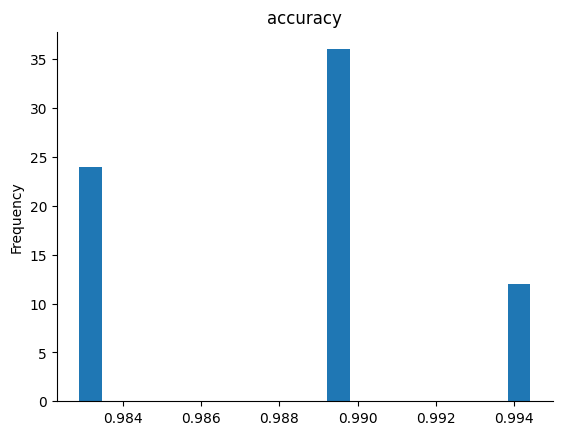

In [25]:
# @title accuracy

from matplotlib import pyplot as plt
all_model_results['accuracy'].plot(kind='hist', bins=20, title='accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [38]:
!pip uninstall graphviz
# !pipenv install graphviz




^C


In [34]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

# Create the decision tree classifier
clf = all_model_results[all_model_results['Iteration'] == 'log_loss - 6 - 200']['Model'].values[0][0]

# Train the classifier with your data

# Assuming you have your data stored in X_train and y_train
# clf.fit(X_train, y_train)

# Visualize the decision tree
dot_data = export_graphviz(clf,
                           out_file = None
                           ,  feature_names = cols
                          #  ,  class_names=True
                           ,  label = 'none'
                           ,  filled=True
                           ,  leaves_parallel = True
                           ,  proportion = True
                           ,  rounded=False
                           ,  special_characters=True)

graphviz.Source(dot_data)
# print(dot_data)



ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

The conclusion is that the model looks for high payers, and it barely cares about withdrawal patterns.

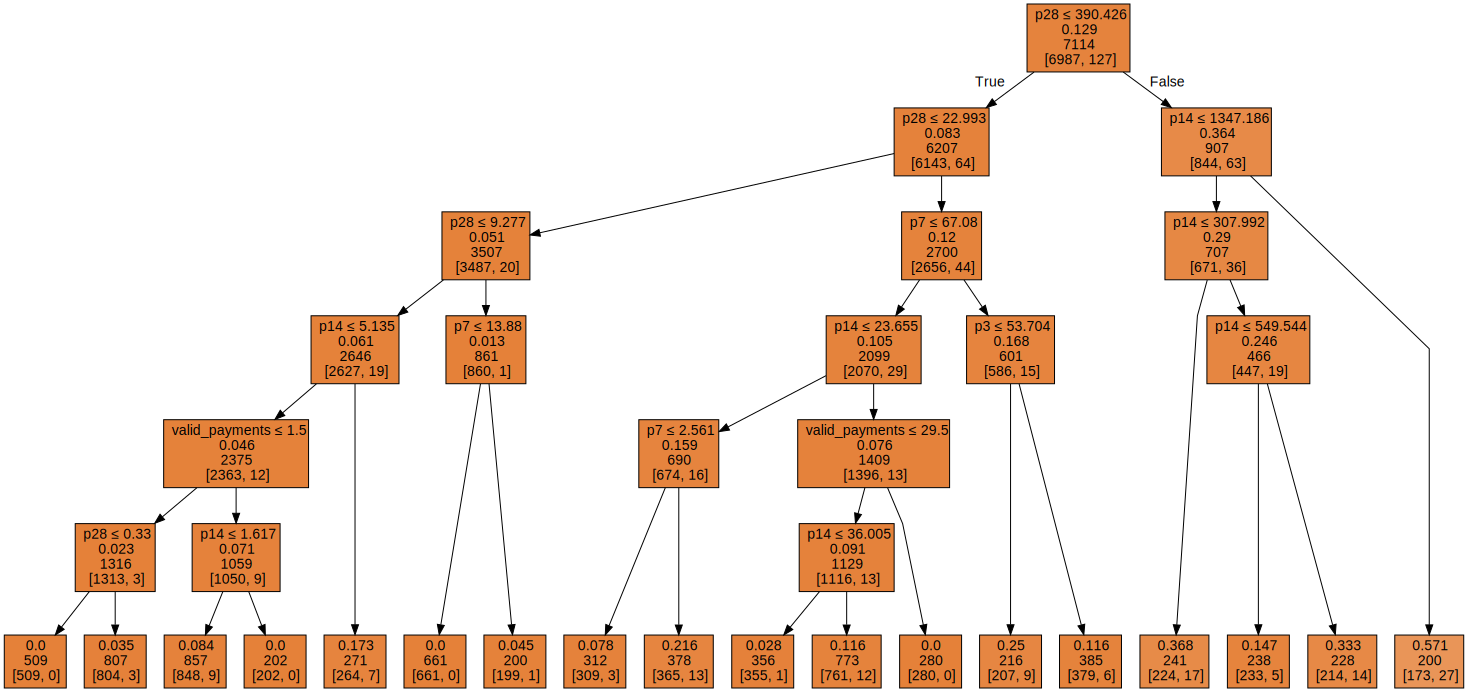

In [112]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

# Create the decision tree classifier

# Train the classifier with your data

# Assuming you have your data stored in X_train and y_train
# clf.fit(X_train, y_train)

# Visualize the decision tree
dot_data = export_graphviz(clf,
                           out_file = None
                           ,  feature_names = cols
                          #  ,  class_names=True
                           ,  label = 'none'
                           ,  filled = True
                           ,  leaves_parallel = True
                          #  ,  proportion = True
                           ,  rounded = False
                           ,  special_characters = True)

graphviz.Source(dot_data)



# Calibration curves

In [11]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=100_000, n_features=20, n_informative=2, n_redundant=10, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.99, random_state=42
)

In [12]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

lr = LogisticRegression(C=1.0)
gnb = GaussianNB()
gnb_isotonic = CalibratedClassifierCV(gnb, cv=2, method="isotonic")
gnb_sigmoid = CalibratedClassifierCV(gnb, cv=2, method="sigmoid")

clf_list = [
    (lr, "Logistic"),
    (gnb, "Naive Bayes"),
    (gnb_isotonic, "Naive Bayes + Isotonic"),
    (gnb_sigmoid, "Naive Bayes + Sigmoid"),
]

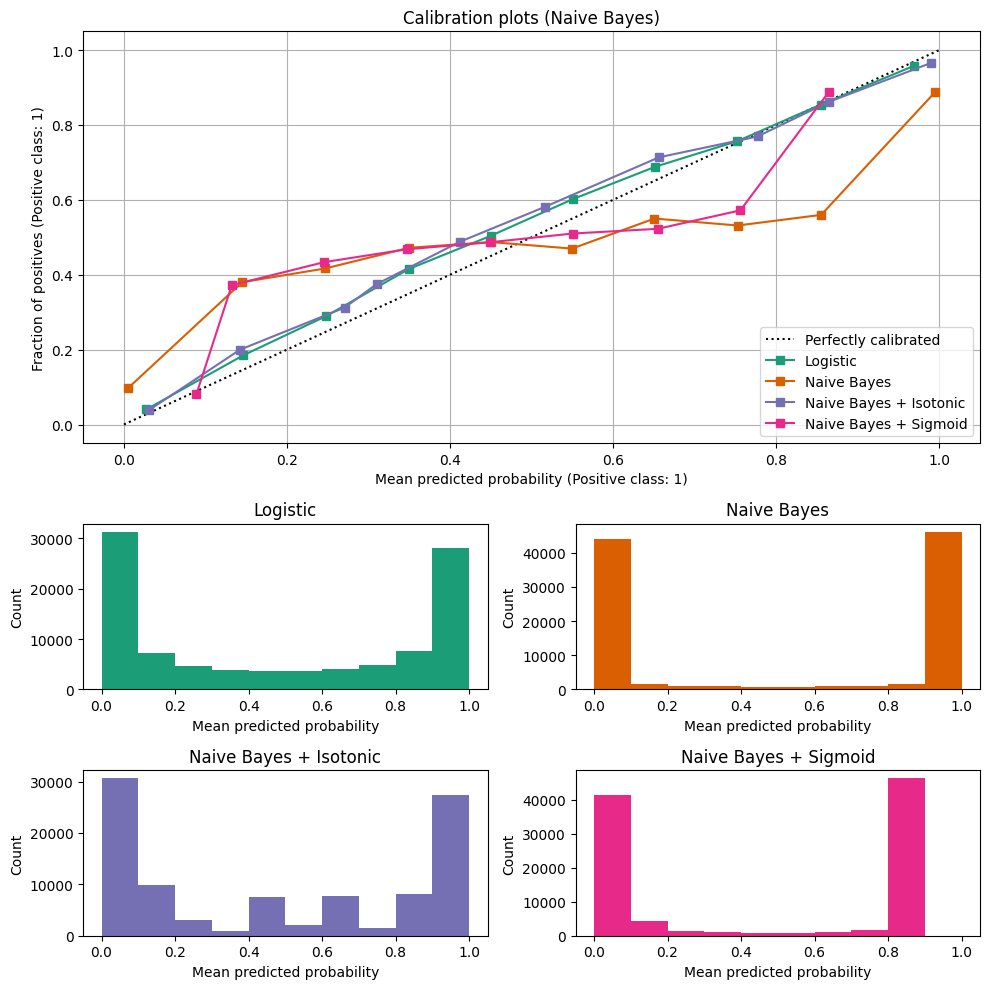

In [13]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots (Naive Bayes)")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

In [29]:
from collections import defaultdict

import pandas as pd

from sklearn.metrics import (
    brier_score_loss,
    f1_score,
    log_loss,
    precision_score,
    recall_score,
    roc_auc_score,
)

scores = defaultdict(list)
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_test)
    y_pred = clf.predict(X_test)
    scores["Classifier"].append(name)

    for metric in [brier_score_loss, log_loss, roc_auc_score]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_test, y_prob[:, 1]))

    for metric in [precision_score, recall_score, f1_score]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_test, y_pred))

    score_df = pd.DataFrame(scores).set_index("Classifier")
    score_df.round(decimals=3)

score_df

,Brier loss,Log loss,Roc auc,Precision,Recall,F1
Classifier,,,,,,
Logistic,0.010188,0.057035,0.617951,0.000000,0.000000,0.000000
Naive Bayes,0.013725,0.094464,0.617951,0.029851,0.012346,0.017467
Naive Bayes + Isotonic,0.010157,0.056078,0.620435,0.000000,0.000000,0.000000
Naive Bayes + Sigmoid,0.010177,0.057219,0.617951,0.000000,0.000000,0.000000
